In [1]:
import numpy as np
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.spatial.distance import pdist
import scipy as sp

In [2]:
from module.convect.entropy_prep import get_ud_all_ent
from module.convect.vectorisation import get_all_vectorisation
from module.data_prep_drosophila import drosophila_data
from module.data_prep_celegans import celegans_data, syn_to_edge


In [3]:
save_things = True # set as True to save data and figures

# _Drosophila_ VNC



## Load data


In [4]:
datadate = '20241119' # date of drosophila VNC data pull
dm_datadir = f'../data/{datadate}_dm_data'

df, meta_df = drosophila_data(datadate=datadate)

## Hemilineage vectorisation and specialization diversity

In [5]:
h_cat_string = 'hemilineage'
hemilineage_fileprefix = f'{dm_datadir}/processed/hemilineage'

h_cat_meta = meta_df[['bodyId', h_cat_string]].rename(columns={'bodyId':'id', h_cat_string:'type'}).copy(True)

categories = [str(category) for category in h_cat_meta.dropna().type.unique()] 
categories.remove('TBD')
all_hemi_vectors = get_all_vectorisation(df=df, meta_df=h_cat_meta, Ids=None, categories=categories, fpath_prefix=hemilineage_fileprefix, entropy=True)

# ~4.5 mins

../data/20241119_dm_data/processed/hemilineage_vec.parquet vector parquet exists.


In [6]:
# Hemilineage vectorisation specialization-diversity
all_hemi_entropies = get_ud_all_ent(df=df, meta_df=h_cat_meta, categories=categories, fpath_prefix=hemilineage_fileprefix)

# ~4.5 mins

../data/20241119_dm_data/processed/hemilineage_ud_ents.parquet upstream/downstream parquet csv exists.


In [7]:
plot_df = meta_df.copy(True)
plot_df = plot_df.join(all_hemi_entropies, on='bodyId')
plot_df['class'] = plot_df['class'].astype(str)


In [8]:
class_filtered_df = plot_df[~plot_df['class'].isin(['glia','TBD', 'nan', 'Unknown', None])].copy(True)


In [9]:
cclasses=['descending neuron', 'sensory neuron', 'motor neuron', 'intrinsic neuron', 'ascending neuron']
toplot_class_filtered_df= class_filtered_df[class_filtered_df['class'].isin(cclasses)]


## Serial homologue statistical testing

In [10]:
serial_sets = meta_df.serial.value_counts()[meta_df.serial.value_counts()==6].index.to_numpy() # only consider sixfold serials?
serial_meta = meta_df.copy(True)
serial_meta.dropna(subset='serial', inplace=True)
serial_meta['serial'] = serial_meta['serial'].astype(int)
serial_series = serial_meta.sort_values(by=['serial', 'instance']).groupby('serial').apply(lambda x: x.bodyId.values)
serials = serial_series[serial_sets].apply(tuple).to_numpy()
serials = np.array([*serials])

In [11]:
cols_for_dist_calc = ['out_diff_ds', 'in_diff_us']


In [12]:
output = []
col_ser_dists= []
for i in serials:
    try:
        col_ser_vdist = pdist(all_hemi_vectors.loc[list(i)].iloc[:, :-2], metric='euclidean')
        col_ser_edist = pdist(all_hemi_entropies.loc[list(i), cols_for_dist_calc], metric='euclidean')

        output.append({'ser':i, 'vd':col_ser_vdist, 'ed':col_ser_edist})
        # col_ser_dists.append(col_ser_dist)
    except:
        output.append({'ser':i, 'vd':None, 'ed':None})
        continue

col_ser_dist_df = pd.DataFrame(output)
# col_ser_vdists = np.hstack(col_ser_dist_df.vd).flatten()
col_ser_edists = np.hstack(col_ser_dist_df.ed).flatten()


In [13]:
serial_roi_shuffled_dists=[]
output=[]
for seed in range(10):
    np.random.seed(seed)
    mixed_serials = np.zeros(serials.shape)
    mixed_serials[:,0] = serials[:,0]
    for i in range(1,6):
        rand_inds = np.random.randint(0,len(mixed_serials)-1, size=len(mixed_serials))
        mixed_serials[:,i] = serials[rand_inds,i]
    rand_id_sample = mixed_serials

    col_sample_dists = []
    for i in rand_id_sample:
        try:
            col_sample_vdist = pdist(all_hemi_vectors.loc[i].iloc[:, :-2], metric='euclidean')
            col_sample_edist = pdist(all_hemi_entropies.loc[i, cols_for_dist_calc], metric='euclidean')

            # col_sample_dists.append(np.mean(col_sample_dist))
            # col_sample_dists.append(col_sample_dist)
            output.append({'ser':i, 'vd':col_sample_vdist, 'ed':col_sample_edist})
        except:
            continue


serial_roi_shuffled_df = pd.DataFrame(output)
# serial_roi_shuffled_vdists = np.hstack(serial_roi_shuffled_df.vd).flatten()
serial_roi_shuffled_edists = np.hstack(serial_roi_shuffled_df.ed).flatten()

## Left-right pair statistical testing

In [14]:
two_groupnames = meta_df.group.value_counts()[meta_df.group.value_counts() == 2].index.astype(int)
group_meta = meta_df.copy(True)
group_meta.dropna(subset='group', inplace=True)
group_meta['group'] = group_meta['group'].astype(int)

group_series = group_meta.sort_values(by=['group', 'instance']).groupby('group').apply(lambda x: x.bodyId.values)
all_ids_group_exist = np.hstack(group_series.values)
pairs = group_series[two_groupnames].apply(tuple).to_numpy()
pairs = np.array([*pairs])
cols_for_dist_calc = ['out_diff_ds', 'in_diff_us']


In [15]:
output = []
for i in pairs:
    try:
        col_pair_vdist = pdist(all_hemi_vectors.loc[i].iloc[:, :-2])
        col_pair_edist = pdist(all_hemi_entropies.loc[i, cols_for_dist_calc])
        output.append({'pair':i, 'vd':col_pair_vdist[0], 'ed':col_pair_edist[0]})
    except:
        output.append({'pair':i, 'vd':None, 'ed':None })
        continue

col_pair_dists_df = pd.DataFrame(output)
# col_pair_vdists = col_pair_dists_df.vd.tolist()
col_pair_edists = col_pair_dists_df.ed.tolist()

In [16]:
output = []

for seed in range(10):
    np.random.seed(seed)
    rand_inds = np.random.randint(0,len(col_pair_dists_df)-1, size=len(col_pair_dists_df))
    rand_id_sample = np.array(list(zip(pairs[:,0], pairs[rand_inds,1])))

    col_sample_dists = []
    for i in rand_id_sample:
        try:
            col_sample_vdist = pdist(all_hemi_vectors.loc[i].iloc[:, :-2])
            col_sample_edist = pdist(all_hemi_entropies.loc[i, cols_for_dist_calc])
            output.append({'sample':i, 'vd':col_sample_vdist[0], 'ed':col_sample_edist[0]})
        except:
            output.append({'sample':i, 'vd':None, 'ed':None })

            continue

col_sample_dists_df = pd.DataFrame(output)
# col_sample_vdists = col_sample_dists_df.vd.tolist()
col_sample_edists = col_sample_dists_df.ed.tolist()

## Plot figure

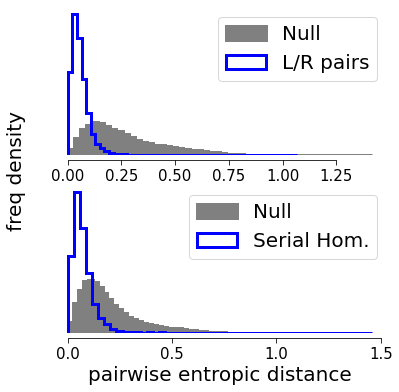

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(6,6 ), sharex=False)

ax[0].hist(col_sample_edists, bins=50, label='Null',color='grey', fill=True, histtype='step', density=True, linewidth=3) # random sample
ax[0].hist(col_pair_edists, bins=50, label='L/R pairs', histtype='step', density=True, linewidth=3, color='blue')
ax[0].set_yticks([])
ax[0].legend(prop={'size': 20})

ax[1].hist(serial_roi_shuffled_edists,color='grey', fill=True, bins=50, label='Null', histtype='step', density=True, linewidth=3) # roi sampled
ax[1].hist(col_ser_edists, bins=50, label='Serial Hom.', histtype='step', density=True, linewidth=3, color='blue')
ax[1].set_yticks([])
ax[1].set_xticks(ticks=[0,.5,1,1.5])

ax[1].tick_params(labelsize=15, size=5)
ax[0].tick_params(labelsize=15, size=5)


ax[1].set_xlabel('pairwise entropic distance', size=20)
fig.supylabel('freq density', size=20)
ax[1].legend(prop={'size': 20})
sns.despine(offset=5, trim=True)
for axis in ax:

    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    # ax[1].spines['bottom'].set_visible(False)
    axis.spines['left'].set_visible(False)
    # axis.spines.bottom.set_bounds(0, 1.5)


if save_things:
    fig.savefig('../figures/r2_sd_null_A_drosophila.png', dpi=300)
plt.show()

In [18]:
sp.stats.ks_2samp(col_pair_edists, col_sample_edists, alternative='two-sided')

KstestResult(statistic=0.697743648084945, pvalue=0.0)

In [19]:
sp.stats.ks_2samp(col_ser_edists, serial_roi_shuffled_edists, alternative='two-sided')

KstestResult(statistic=0.5148506860371267, pvalue=0.0)

# _C. elegans_

## Load data

In [20]:
edge_df, ce_meta = celegans_data()

In [21]:
chem_edges_df = syn_to_edge(edge_df, electrical=False)

all_edges_df = syn_to_edge(edge_df, electrical=True)

In [22]:
strings_list = ['Anatomical cell class (WW Barry)', 'Cook cell category', 'Cell Class', 'Final classification']

shorthand = {'Anatomical cell class (WW Barry)':'cellclass', \
             'Cook cell category':'cook_ccat', \
             'Cell Class':'ncclass', 'Final classification':'fclass'}

edge_dict = {'chem':chem_edges_df, 'all':all_edges_df}


for class_string in strings_list:
    class_meta = ce_meta.reset_index()[['Neuron', class_string]].rename(columns={'Neuron':'id', class_string:'type'}).copy(True)
    class_name = shorthand.get(class_string)
    todir = f'../data/celegans/processed/{class_name}'
    if not os.path.isdir(todir):
        os.mkdir(todir)
    for edgetype in edge_dict.keys():
        typeedge_df = edge_dict.get(edgetype)
        edgetype_class_ents = get_ud_all_ent(df=typeedge_df, meta_df=class_meta, categories=None, fpath_prefix=f'{todir}/V_{class_name}_{edgetype}')
# 44s

../data/celegans/processed/cellclass/V_cellclass_chem_ud_ents.parquet upstream/downstream parquet csv exists.
../data/celegans/processed/cellclass/V_cellclass_all_ud_ents.parquet upstream/downstream parquet csv exists.
../data/celegans/processed/cook_ccat/V_cook_ccat_chem_ud_ents.parquet upstream/downstream parquet csv exists.
../data/celegans/processed/cook_ccat/V_cook_ccat_all_ud_ents.parquet upstream/downstream parquet csv exists.
../data/celegans/processed/ncclass/V_ncclass_chem_ud_ents.parquet upstream/downstream parquet csv exists.
../data/celegans/processed/ncclass/V_ncclass_all_ud_ents.parquet upstream/downstream parquet csv exists.
../data/celegans/processed/fclass/V_fclass_chem_ud_ents.parquet upstream/downstream parquet csv exists.
../data/celegans/processed/fclass/V_fclass_all_ud_ents.parquet upstream/downstream parquet csv exists.


In [23]:

class_string = 'Cook cell category'
class_name = shorthand.get(class_string)

edgetype='all'
ent_dir = f'../data/celegans/processed/{class_name}/V_{class_name}_{edgetype}_ud_ents.parquet'
vec_dir = f'../data/celegans/processed/{class_name}/V_{class_name}_{edgetype}_vec.parquet'

read_vec = pd.read_parquet(vec_dir)
vecs = read_vec.iloc[:, :-2]
vec_ent = read_vec.iloc[:, -2:]


spec_div = pd.read_parquet(ent_dir)



In [24]:

to_plot = ce_meta.copy(True).reset_index()
to_plot = to_plot.join(spec_div, on='Neuron')



In [25]:

fig_to_plot = to_plot.rename(columns={'Final classification':'Cell class', 'deg':'Degree'})
fig_to_plot = fig_to_plot[fig_to_plot['Cell class']!='unknown']


In [26]:
# specify the specialization-diversities to take entropic euclidean distances of...
cols_for_dist_calc = ['out_diff_ds', 'in_diff_us']


## Calculate all neuron by all neuron pairwise entropic distances

In [27]:
class2neuron_dict = ce_meta.reset_index().groupby('Cell Class').Neuron.apply(list).to_dict()

fclass2neuron_dict = ce_meta.reset_index().groupby('Final classification').Neuron.apply(list).to_dict()

aclass2neuron_dict = ce_meta.reset_index().groupby('Anatomical cell class (WW Barry)').Neuron.apply(list).to_dict()
cclass2neuron_dict = ce_meta.reset_index().groupby('Cook cell category').Neuron.apply(list).to_dict()

In [28]:
output = []
col_ser_dists= []

for fc, neurons in class2neuron_dict.items():
    sliced_sd = spec_div[spec_div.index.isin(neurons)]


    if len(sliced_sd) > 1:
        col_class_dist = pdist(sliced_sd.loc[:, cols_for_dist_calc], metric='euclidean')
        class_vdists = pdist(vecs[vecs.index.isin(neurons)], metric='euclidean')
        output.append({'fc_name':fc, 'vd':class_vdists, 'ed':col_class_dist})
col_class_dist_df = pd.DataFrame(output)

# flat_class_vdists = np.hstack(col_class_dist_df.vd)
flat_class_edists = np.hstack(col_class_dist_df.ed)

In [29]:

ent_exists = spec_div.index.tolist()
aba_vdist = pdist(vecs)
aba_edist = pdist(spec_div.loc[:,cols_for_dist_calc])


## Calculate entropic Euclidean distances between cell types and pairs

In [30]:
output = []
col_ser_dists= []

for fc, neurons in class2neuron_dict.items():
    sliced_sd = spec_div[spec_div.index.isin(neurons)]


    if len(sliced_sd) > 1:
        col_class_dist = pdist(sliced_sd.loc[:, cols_for_dist_calc], metric='euclidean')
        class_vdists = pdist(vecs[vecs.index.isin(neurons)], metric='euclidean')
        output.append({'fc_name':fc, 'vd':class_vdists, 'ed':col_class_dist})
col_class_dist_df = pd.DataFrame(output)

flat_class_edists = np.hstack(col_class_dist_df.ed)

## Left-right pairs statistical testing

In [31]:
neurons = ce_meta.index.values
lr_labelled = [i for i in neurons if (i[-1] == 'L') or (i[-1]=='R')]

track_pairs = {}

for i in lr_labelled:
    pair_id = i[:-1]
    if track_pairs.get(pair_id)==None:
        track_pairs[pair_id] = [i]
        continue
    track_pairs[pair_id].append(i)
    
pair_ids = [pid for pid,val in track_pairs.items() if len(val)==2]
pair_arr = np.array([track_pairs[i] for i in pair_ids])

In [32]:
output = []
for i in pair_arr:
    sliced_sd = spec_div[spec_div.index.isin(i)]
    if len(sliced_sd) > 1:
        col_pair_vdist = pdist(vecs.loc[i])
        col_pair_edist = pdist(sliced_sd.loc[i, cols_for_dist_calc])
        output.append({'pair':i, 'vd':col_pair_vdist[0], 'ed':col_pair_edist[0]})

col_pair_dists_df = pd.DataFrame(output) # data frame of pair distances. 
col_pair_edists = col_pair_dists_df.ed.values

In [33]:
output = []

for seed in range(10): # 10 realizations.
    np.random.seed(seed)
    rand_inds = np.random.randint(0,len(col_pair_edists)-1, size=len(col_pair_edists))
    rand_id_sample = np.array(list(zip(pair_arr[:,0], pair_arr[rand_inds,1])))

    for i in rand_id_sample:
        sliced_sd = spec_div[spec_div.index.isin(i)]
        if len(sliced_sd) > 1:
            col_pair_vdist = pdist(vecs.loc[i])
            col_pair_edist = pdist(sliced_sd.loc[i, cols_for_dist_calc])
            output.append({'pair':i, 'vd':col_pair_vdist[0], 'ed':col_pair_edist[0]})

col_samplepair_dists_df = pd.DataFrame(output) # data frame of pair sampled distances
col_samplepair_edists = col_samplepair_dists_df.ed.values

## Plot figure

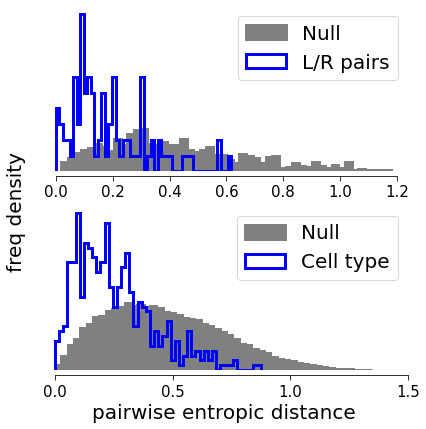

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(6,6 ), sharex=False)
ax[0].hist(col_samplepair_edists, bins=50, label='Null', histtype='step', density=True, linewidth=3, color='grey', fill=True) # random sample
ax[0].hist(col_pair_edists, bins=50, label='L/R pairs', histtype='step', density=True, linewidth=3, color='blue') 
ax[0].set_yticks([])
ax[0].legend(prop={'size': 20})
ax[0].tick_params(labelsize=15, size=5)

ax[1].hist(aba_edist, bins=50, label='Null', histtype='step', density=True, linewidth=3, color='grey', fill=True) # all by all!
ax[1].hist(flat_class_edists, bins=50, label='Cell type', histtype='step', density=True, linewidth=3, color='blue')
ax[1].set_yticks([])
ax[1].set_xticks(ticks=[0,.5,1,1.5])
ax[1].tick_params(labelsize=15, size=5)
ax[1].set_xlabel('pairwise entropic distance', size=20)
ax[1].legend(prop={'size': 20})

fig.supylabel('freq density', size=20)
plt.tight_layout()
sns.despine(offset=5, trim=True)

for axis in ax:

    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['left'].set_visible(False)
if save_things:
    fig.savefig('../figures/r2_sd_null_B_celegans.png', dpi=300)
plt.show()

In [35]:
sp.stats.ks_2samp(col_pair_edists, col_samplepair_edists, alternative='two-sided')

KstestResult(statistic=0.47585811871526157, pvalue=6.144587374638144e-19)

In [36]:
sp.stats.ks_2samp(flat_class_edists, aba_edist, alternative='two-sided')

KstestResult(statistic=0.39056191727701256, pvalue=3.595678452672523e-70)